In [1]:
import itertools
import math
import numpy as np
import pandas as pd

try:
    from scipy.stats import norm
    _has_scipy = True
except Exception:
    _has_scipy = False

import matplotlib.pyplot as plt
from itertools import product



Load dataframe and join data 

In [2]:
base_path       = "../Data/btc_final_df.csv"
egarch_path     = "../Results/btc_egarch_prediction.csv"
lstm_path       = "../Results/btc_lstm_prediction.csv"
xgb_path        = "../Results/btc_xgb_prediction.csv"
vanilla_t_path  = "../Results/btc_transformer_prediction.csv"
dense_t_path = "../Results/btc_transformer_dense_prediction.csv"
random_t_path = "../Results/btc_transformer_random_prediction.csv"


H = 1  # forecast horizon for DM (h-step ahead)
ASSUME_INPUTS_ARE_VOL = True  # True if columns are volatility (sigma), False if already variance 
SAVE_DM_CSV = "../Results/btc_dm_results.csv"  

def load_actual(base_path):
    df = pd.read_csv(base_path, parse_dates=["timestamp"])
    need = ["timestamp", "vol_future"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError("Missing columns in base file: " + ", ".join(missing))
    df = df[need].copy()
    if df["timestamp"].dt.tz is None:
        df["timestamp"] = df["timestamp"].dt.tz_localize("UTC")
    df = df.drop_duplicates(subset="timestamp").sort_values("timestamp")
    return df.rename(columns={"vol_future": "actual_vol"})

def load_pred(path, new_col_name):
    d = pd.read_csv(path, parse_dates=["timestamp"])
    if d["timestamp"].dt.tz is None:
        d["timestamp"] = d["timestamp"].dt.tz_localize("UTC")
    pred_col = None
    for c in d.columns:
        if c.lower() in {"pred_vol_future", "predicted_volatility", "predicted"}:
            pred_col = c
            break
    if pred_col is None:
        raise ValueError("Could not find prediction column in " + path)
    d = d[["timestamp", pred_col]].rename(columns={pred_col: new_col_name})
    return d.drop_duplicates(subset="timestamp").sort_values("timestamp")

actual = load_actual(base_path)

pred_dfs = []
for path, name in [
    (egarch_path, "pred_egarch"),
    (xgb_path, "pred_xgb"),
    (lstm_path, "pred_lstm"),
    (vanilla_t_path, "pred_vanilla_t"),
    (dense_t_path, "pred_dense_t"),
    (random_t_path, "pred_random_t")
]:
    pred_dfs.append(load_pred(path, name))
    

df = actual.copy()
for p in pred_dfs:
    df = df.merge(p, on="timestamp", how="inner")

df = df.sort_values("timestamp").drop_duplicates(subset=["timestamp"]).reset_index(drop=True)

print("=== Joined Data Preview (first 10 rows) ===")
display(df.head(10))
print("[info] shape:", df.shape)
print("[info] columns:", list(df.columns))

=== Joined Data Preview (first 10 rows) ===


,timestamp,actual_vol,pred_egarch,pred_xgb,pred_lstm,pred_vanilla_t,pred_dense_t,pred_random_t
0,2025-08-22 17:00:00+00:00,-4.977060,-4.608829,-5.051687,-5.275604,0.006482,0.006052,1.0
1,2025-08-22 18:00:00+00:00,-5.685779,-4.724276,-5.295076,-5.425174,0.004094,0.004495,1.0
2,2025-08-22 19:00:00+00:00,-5.964853,-4.866921,-5.208465,-5.316171,0.005164,0.005559,1.0
3,2025-08-22 20:00:00+00:00,-5.934881,-5.003807,-5.426212,-5.512246,0.003481,0.003988,1.0
4,2025-08-22 21:00:00+00:00,-5.818036,-5.102895,-5.648346,-5.676215,0.003132,0.003309,1.0
5,2025-08-22 22:00:00+00:00,-6.370835,-5.212878,-5.609450,-5.686630,0.002885,0.003076,1.0
6,2025-08-22 23:00:00+00:00,-5.801953,-5.238839,-5.568606,-5.726196,0.002910,0.002940,1.0
7,2025-08-23 00:00:00+00:00,-5.839813,-5.336262,-5.851039,-5.916484,0.002316,0.002447,1.0
8,2025-08-23 01:00:00+00:00,-5.343040,-5.456688,-5.687985,-5.787280,0.002842,0.002963,1.0
9,2025-08-23 02:00:00+00:00,-5.839386,-5.421705,-5.786499,-5.814778,0.002759,0.002848,1.0


[info] shape: (1231, 8)
[info] columns: ['timestamp', 'actual_vol', 'pred_egarch', 'pred_xgb', 'pred_lstm', 'pred_vanilla_t', 'pred_dense_t', 'pred_random_t']


Define Squared Error and QLIKE 

In [3]:
def squared_error(y, yhat):
    return (y - yhat) ** 2

def qlike(y, yhat, inputs_are_volatility=True, eps=1e-12):
    if inputs_are_volatility:
        y_var = (y ** 2).astype(float)
        yhat_var = (yhat ** 2).astype(float)
    else:
        y_var = y.astype(float)
        yhat_var = yhat.astype(float)
    yhat_var = np.clip(yhat_var, eps, None)
    return np.log(yhat_var) + (y_var / yhat_var)

model_cols = [c for c in df.columns if c.startswith("pred_")]
for mc in model_cols:
    se_col = mc.replace("pred_", "") + "_se"
    ql_col = mc.replace("pred_", "") + "_qlike"
    df[se_col] = squared_error(df["actual_vol"], df[mc])
    df[ql_col] = qlike(df["actual_vol"], df[mc], inputs_are_volatility=ASSUME_INPUTS_ARE_VOL)

print("=== Loss Columns Preview (first 10 rows) ===")
loss_cols = ["timestamp", "actual_vol"] + model_cols + \
            [mc.replace("pred_", "") + "_se" for mc in model_cols] + \
            [mc.replace("pred_", "") + "_qlike" for mc in model_cols]
display(df[loss_cols].head(10))


=== Loss Columns Preview (first 10 rows) ===


,timestamp,actual_vol,pred_egarch,pred_xgb,pred_lstm,pred_vanilla_t,pred_dense_t,pred_random_t,egarch_se,xgb_se,lstm_se,vanilla_t_se,dense_t_se,random_t_se,egarch_qlike,xgb_qlike,lstm_qlike,vanilla_t_qlike,dense_t_qlike,random_t_qlike
0,2025-08-22 17:00:00+00:00,-4.977060,-4.608829,-5.051687,-5.275604,0.006482,0.006052,1.0,0.135594,0.005569,0.089129,24.835686,24.831406,35.725245,4.222125,4.210117,4.216210,5.896115e+05,6.762515e+05,24.771124
1,2025-08-22 18:00:00+00:00,-5.685779,-4.724276,-5.295076,-5.425174,0.004094,0.004495,1.0,0.924488,0.152649,0.067915,32.374653,32.379220,44.699643,4.553898,4.486571,4.480480,1.929012e+06,1.599948e+06,32.328083
2,2025-08-22 19:00:00+00:00,-5.964853,-4.866921,-5.208465,-5.316171,0.005164,0.005559,1.0,1.205453,0.572123,0.420789,35.641099,35.645822,48.509176,4.666995,4.612106,4.600437,1.334303e+06,1.151188e+06,35.579468
3,2025-08-22 20:00:00+00:00,-5.934881,-5.003807,-5.426212,-5.512246,0.003481,0.003988,1.0,0.866900,0.258744,0.178621,35.264141,35.270173,48.092579,4.627168,4.578756,4.573167,2.907590e+06,2.214232e+06,35.222815
4,2025-08-22 21:00:00+00:00,-5.818036,-5.102895,-5.648346,-5.676215,0.003132,0.003309,1.0,0.511427,0.028795,0.020113,33.886000,33.888061,46.485620,4.559545,4.523713,4.523164,3.450967e+06,3.091506e+06,33.849546
5,2025-08-22 22:00:00+00:00,-6.370835,-5.212878,-5.609450,-5.686630,0.002885,0.003076,1.0,1.340863,0.579707,0.468136,40.624299,40.626738,54.329204,4.795875,4.738794,4.731348,4.877412e+06,4.289535e+06,40.587533
6,2025-08-22 23:00:00+00:00,-5.801953,-5.238839,-5.568606,-5.726196,0.002910,0.002940,1.0,0.317098,0.054451,0.005739,33.696438,33.696785,46.266566,4.538730,4.519854,4.516738,3.974612e+06,3.894095e+06,33.662658
7,2025-08-23 00:00:00+00:00,-5.839813,-5.336262,-5.851039,-5.916484,0.002316,0.002447,1.0,0.253563,0.000126,0.005879,34.130463,34.131995,46.783037,4.546683,4.529405,4.529735,6.359510e+06,5.696214e+06,34.103410
8,2025-08-23 01:00:00+00:00,-5.343040,-5.456688,-5.687985,-5.787280,0.002842,0.002963,1.0,0.012916,0.118987,0.197349,28.578453,28.579752,40.234160,4.352463,4.359101,4.363694,3.535578e+06,3.251568e+06,28.548078
9,2025-08-23 02:00:00+00:00,-5.839386,-5.421705,-5.786499,-5.814778,0.002759,0.002848,1.0,0.174458,0.002797,0.000606,34.130660,34.131700,46.777205,4.540833,4.529418,4.529287,4.479970e+06,4.204105e+06,34.098431


Create DM helpers 

In [4]:
# Compute a robust variance of that difference series (accounting for autocorrelation)
def _nw_longrun_var(d, h):
    d = np.asarray(d, dtype=float)
    T = d.size
    d = d - d.mean()
    def acov(k):
        return np.dot(d[:T - k], d[k:]) / T
    gamma0 = acov(0)
    q = max(h - 1, 0)
    lrv = gamma0
    for k in range(1, q + 1):
        w = 1.0 - k / (q + 1.0)
        lrv += 2.0 * w * acov(k)
    return lrv

#Takes two loss series (e.g. squared error or QLIKE) from two models and computes DM statistic and p-value

def dm_test_from_losses(loss_a, loss_b, h=1):
    d = (loss_a - loss_b).dropna().to_numpy()
    T = d.size
    if T < 5:
        raise ValueError("Not enough overlapping observations for DM test.")
    dbar = d.mean()
    lrv = _nw_longrun_var(d, h)
    if lrv <= 0:
        lrv = np.var(d, ddof=1)
    dm = dbar / math.sqrt(lrv / T)
    hln = math.sqrt((T + 1 - 2 * h + (h * (h - 1)) / T) / T)
    dm_hln = dm * hln
    if _has_scipy:
        pval = 2.0 * (1.0 - norm.cdf(abs(dm_hln)))
    else:
        def norm_cdf(x):
            return 0.5 * (1.0 + math.erf(x / math.sqrt(2)))
        pval = 2.0 * (1.0 - norm_cdf(abs(dm_hln)))
    return dm_hln, pval, dbar


Run pairwise DM tests

In [5]:
# build maps
name_map = {mc: mc.replace("pred_", "") for mc in model_cols}
se_map = {name_map[mc]: name_map[mc] + "_se" for mc in model_cols}
ql_map = {name_map[mc]: name_map[mc] + "_qlike" for mc in model_cols}

# pairwise comparisons
results = []
pairs = list(itertools.combinations(name_map.values(), 2))
for a, b in pairs:
    stat_se, p_se, mean_diff_se = dm_test_from_losses(df[se_map[a]], df[se_map[b]], h=H)
    stat_ql, p_ql, mean_diff_ql = dm_test_from_losses(df[ql_map[a]], df[ql_map[b]], h=H)
    results.append({
        "loss": "SE",
        "model_A": a, "model_B": b,
        "T": int(df[[se_map[a], se_map[b]]].dropna().shape[0]),
        "dm_stat": stat_se, "p_value": p_se, "mean_diff_A_minus_B": mean_diff_se,
        "better_model": b if mean_diff_se > 0 else a if mean_diff_se < 0 else "tie"
    })
    results.append({
        "loss": "QLIKE",
        "model_A": a, "model_B": b,
        "T": int(df[[ql_map[a], ql_map[b]]].dropna().shape[0]),
        "dm_stat": stat_ql, "p_value": p_ql, "mean_diff_A_minus_B": mean_diff_ql,
        "better_model": b if mean_diff_ql > 0 else a if mean_diff_ql < 0 else "tie"
    })

dm_df = pd.DataFrame(results)

# save combined 
if SAVE_DM_CSV:
    dm_df.sort_values(["loss", "p_value"]).reset_index(drop=True).to_csv(SAVE_DM_CSV, index=False)
    print("[info] saved DM test summary to", SAVE_DM_CSV)


dm_se = dm_df[dm_df["loss"] == "SE"].sort_values("p_value").reset_index(drop=True)
dm_ql = dm_df[dm_df["loss"] == "QLIKE"].sort_values("p_value").reset_index(drop=True)

print("=== Diebold–Mariano Results (Squared Error basis) ===")
display(dm_se)

print("=== Diebold–Mariano Results (QLIKE basis) ===")
display(dm_ql)


[info] saved DM test summary to ../Results/btc_dm_results.csv
=== Diebold–Mariano Results (Squared Error basis) ===


,loss,model_A,model_B,T,dm_stat,p_value,mean_diff_A_minus_B,better_model
0,SE,egarch,xgb,1231,14.529858,0.000000e+00,0.131637,xgb
1,SE,egarch,lstm,1231,16.363584,0.000000e+00,0.171019,lstm
2,SE,egarch,vanilla_t,1231,-172.286769,0.000000e+00,-35.159776,egarch
3,SE,egarch,dense_t,1231,-172.294046,0.000000e+00,-35.160721,egarch
4,SE,egarch,random_t,1231,-200.239263,0.000000e+00,-47.976399,egarch
5,SE,xgb,vanilla_t,1231,-171.121034,0.000000e+00,-35.291413,xgb
6,SE,xgb,dense_t,1231,-171.127936,0.000000e+00,-35.292358,xgb
7,SE,xgb,random_t,1231,-198.984563,0.000000e+00,-48.108036,xgb
8,SE,lstm,vanilla_t,1231,-168.712747,0.000000e+00,-35.330795,lstm
9,SE,lstm,dense_t,1231,-168.719661,0.000000e+00,-35.331740,lstm


=== Diebold–Mariano Results (QLIKE basis) ===


,loss,model_A,model_B,T,dm_stat,p_value,mean_diff_A_minus_B,better_model
0,QLIKE,egarch,xgb,1231,15.250207,0.000000e+00,8.776285e-03,xgb
1,QLIKE,egarch,lstm,1231,17.226110,0.000000e+00,1.108941e-02,lstm
2,QLIKE,egarch,vanilla_t,1231,-47.345211,0.000000e+00,-6.660202e+06,egarch
3,QLIKE,egarch,dense_t,1231,-42.375467,0.000000e+00,-6.462819e+06,egarch
4,QLIKE,egarch,random_t,1231,-153.639795,0.000000e+00,-3.092705e+01,egarch
5,QLIKE,xgb,lstm,1231,8.607043,0.000000e+00,2.313125e-03,lstm
6,QLIKE,xgb,vanilla_t,1231,-47.345211,0.000000e+00,-6.660202e+06,xgb
7,QLIKE,xgb,dense_t,1231,-42.375467,0.000000e+00,-6.462819e+06,xgb
8,QLIKE,xgb,random_t,1231,-153.575414,0.000000e+00,-3.093583e+01,xgb
9,QLIKE,lstm,vanilla_t,1231,-47.345211,0.000000e+00,-6.660202e+06,lstm


Helpers for Matrix and HeatMap 

In [6]:
def get_models(dm_df: pd.DataFrame) -> list[str]:
    return sorted(set(dm_df['model_A']).union(set(dm_df['model_B'])))

def build_leaderboard(dm_df: pd.DataFrame, loss: str, alpha: float = 0.05) -> pd.DataFrame:
    df = dm_df.loc[dm_df['loss'].str.upper() == loss.upper()].copy()
    models = get_models(df)

    wins = {m: 0 for m in models}
    losses = {m: 0 for m in models}

    for _, r in df.iterrows():
        if r['p_value'] < alpha:
            a, b = r['model_A'], r['model_B']
            winner = r['better_model']
            loser  = b if winner == a else a
            wins[winner]  += 1
            losses[loser] += 1

    board = pd.DataFrame([
        dict(Model=m, Sig_Wins=wins[m], Sig_Losses=losses[m], Net_Wins=wins[m]-losses[m])
        for m in models
    ]).sort_values('Net_Wins', ascending=False, ignore_index=True)
    return board

def _pairwise_matrix(dm_df: pd.DataFrame, models: list[str], alpha: float = 0.05):
    idx = pd.Index(models, name='row')
    col = pd.Index(models, name='col')
    W = pd.DataFrame(0, index=idx, columns=col, dtype=float)
    P = pd.DataFrame(np.nan, index=idx, columns=col, dtype=float)
    E = pd.DataFrame(0.0, index=idx, columns=col, dtype=float)

    for _, r in dm_df.iterrows():
        a, b = r['model_A'], r['model_B']
        p = r['p_value']
        eff = abs(r['mean_diff_A_minus_B'])
        winner = r['better_model']

        P.loc[a, b] = p
        E.loc[a, b] = eff

        if p < alpha:
            W.loc[a, b] = 1.0 if winner == a else -1.0
        else:
            W.loc[a, b] = 0.0
    return W, P, E


def plot_dm_heatmap(dm_df: pd.DataFrame, loss: str, alpha: float = 0.05, title: str | None = None):
    df = dm_df.loc[dm_df['loss'].str.upper() == loss.upper()].copy()
    models = get_models(df)
    W, P, E = _pairwise_matrix(df, models, alpha=alpha)

    emax = E.to_numpy().max() or 1.0
    A = E / emax 
    Z = W.to_numpy()

    fig, ax = plt.subplots(figsize=(0.9*len(models)+2, 0.9*len(models)+2))
    im = ax.imshow(Z, vmin=-1, vmax=1)

    for i, j in product(range(len(models)), range(len(models))):
        if i == j:
            continue
        wij = W.iat[i, j]
        pij = P.iat[i, j]
        if np.isnan(pij):
            text = ''
        else:
            text = 'W' if wij > 0 else ('L' if wij < 0 else '')
            if pij < 0.01:
                text += '**'
            elif pij < 0.05:
                text += '*'
        ax.text(j, i, text, ha='center', va='center', fontsize=10, color='black')

    for i, j in product(range(len(models)), range(len(models))):
        if i == j:
            continue
        rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, 
                             facecolor='white', 
                             alpha=(1.0 - float(A.iat[i, j])), 
                             edgecolor='none')
        ax.add_patch(rect)


    for d in range(len(models)):
        rect = plt.Rectangle((d-0.5, d-0.5), 1, 1, facecolor='white', edgecolor='none')
        ax.add_patch(rect)

    ax.set_xticks(range(len(models)))
    ax.set_yticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_yticklabels(models)
    ax.set_title(title or f"Pair-wise DM ({loss.upper()})")

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Row wins (+) vs. loses (−)')

    plt.tight_layout()
    plt.show()

=== Leaderboard (RMSE / SE) ===


,Model,Sig_Wins,Sig_Losses,Net_Wins
0,lstm,5,0,5
1,xgb,4,1,3
2,egarch,3,2,1
3,vanilla_t,2,3,-1
4,dense_t,1,4,-3
5,random_t,0,5,-5



=== Leaderboard (QLIKE) ===


,Model,Sig_Wins,Sig_Losses,Net_Wins
0,lstm,5,0,5
1,xgb,4,1,3
2,egarch,3,2,1
3,random_t,2,3,-1
4,dense_t,1,4,-3
5,vanilla_t,0,5,-5


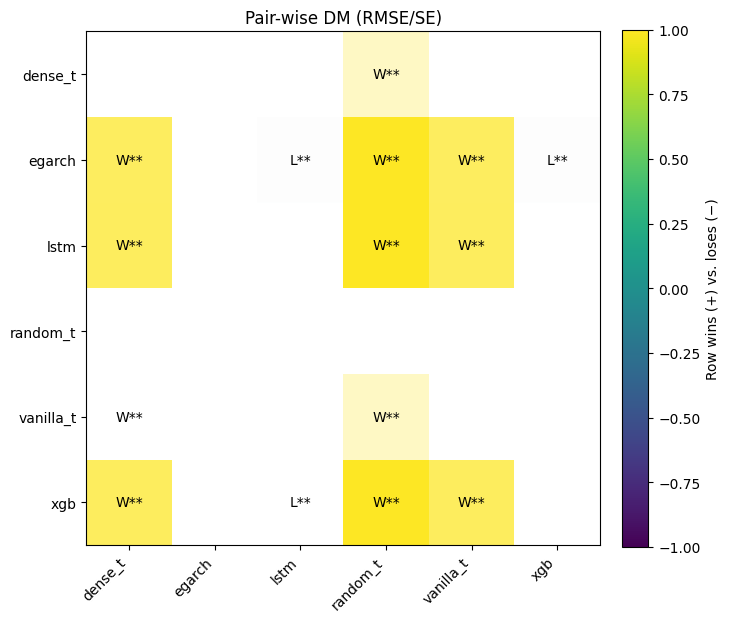

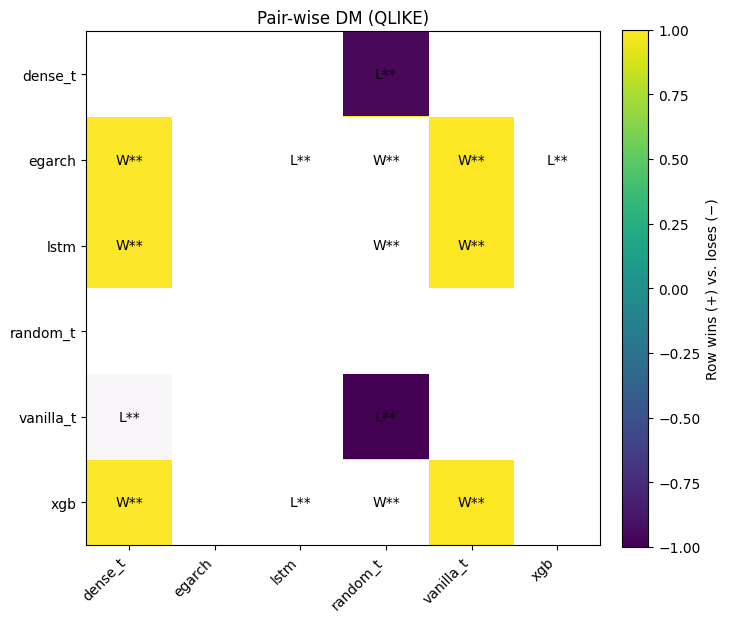

In [7]:
models = get_models(dm_df)

# Leaderboards
lb_rmse  = build_leaderboard(dm_df, loss='SE',    alpha=0.05)
lb_qlike = build_leaderboard(dm_df, loss='QLIKE', alpha=0.05)

print("=== Leaderboard (RMSE / SE) ===")
display(lb_rmse)

print("\n=== Leaderboard (QLIKE) ===")
display(lb_qlike)

# Separate heatmaps
plot_dm_heatmap(dm_df, loss='SE',    alpha=0.05, title="Pair-wise DM (RMSE/SE)")
plot_dm_heatmap(dm_df, loss='QLIKE', alpha=0.05, title="Pair-wise DM (QLIKE)")

